In [1]:
import numpy as np
import pandas as pd
import gymnasium as gym
import matplotlib.pyplot as plt

from env_any_1 import TradingEnv, StocksEnv, Actions, Positions 


## Read training data

In [2]:
def read_adjusted_history_ohlcv(path_csv):
    history = pd.read_csv(path_csv, parse_dates=["Date"], index_col='Date', \
        dtype={'Open': float, 'High': float, 'Low': float, 'Close': float,'Volume': float})
    history.drop('Adj Close', axis=1, inplace=True)
    history = history.rename(columns={'Open': 'open', 'High': 'high', 'Low': 'low', 'Close': 'close', 'Volume': 'volume'})
    history.sort_index(inplace= True)
    history.dropna(inplace= True)
    history.drop_duplicates(inplace=True)
    return history

price_history = read_adjusted_history_ohlcv('yfinance/googl.1d.adjusted.csv')
price_history

,open,high,low,close,volume
Date,,,,,
2009-05-22,198.528534,199.524521,196.196198,196.946945,3433700.0
2009-05-26,196.171173,202.702698,195.195190,202.382385,6202700.0
2009-05-27,203.023026,206.136139,202.607605,202.982986,6062500.0
2009-05-28,204.544540,206.016022,202.507507,205.405411,5332200.0
2009-05-29,206.261261,208.823822,205.555557,208.823822,5291100.0
...,...,...,...,...,...
2018-08-23,1219.880005,1235.170044,1219.349976,1221.160034,1233300.0
2018-08-24,1226.000000,1237.400024,1221.420044,1236.750000,1222700.0
2018-08-27,1244.140015,1257.869995,1240.680054,1256.270020,1429000.0


## Generate features

In [3]:
price_history['median'] = (price_history['high'] + price_history['low']) / 2
price_history['typical'] = (price_history['high'] + price_history['low'] + price_history['close']) / 3

price_history["f_open"] = price_history["open"]/price_history["close"]
price_history["f_high"] = price_history["high"]/price_history["close"]
price_history["f_low"] = price_history["low"]/price_history["close"]
price_history["f_close"] = price_history["close"].pct_change()
price_history["f_volume"] = price_history["volume"] / price_history["volume"].rolling(252).max()

price_history.dropna(inplace= True)
price_history

,open,high,low,close,volume,median,typical,f_open,f_high,f_low,f_close,f_volume
Date,,,,,,,,,,,,
2010-05-21,234.764771,242.742737,232.432434,236.261261,19362200.0,237.587585,237.145477,0.993666,1.027434,0.983794,-0.006231,0.792023
2010-05-24,240.605606,245.140137,238.638641,238.818817,8682500.0,241.889389,240.865865,1.007482,1.026469,0.999246,0.010825,0.355163
2010-05-25,234.309311,238.963959,232.237244,238.773773,6028700.0,235.600601,236.658325,0.981303,1.000797,0.972625,-0.000189,0.246608
2010-05-26,241.276276,245.125122,237.737732,237.972977,6944200.0,241.431427,240.278610,1.013881,1.030054,0.999011,-0.003354,0.284057
2010-05-27,242.717712,246.401398,240.765762,245.475479,5612500.0,243.583580,244.214213,0.988766,1.003772,0.980814,0.031527,0.229583
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-23,1219.880005,1235.170044,1219.349976,1221.160034,1233300.0,1227.260010,1225.226685,0.998952,1.011473,0.998518,-0.000483,0.192372
2018-08-24,1226.000000,1237.400024,1221.420044,1236.750000,1222700.0,1229.410034,1231.856689,0.991308,1.000526,0.987605,0.012767,0.190719
2018-08-27,1244.140015,1257.869995,1240.680054,1256.270020,1429000.0,1249.275024,1251.606690,0.990344,1.001274,0.987590,0.015783,0.222898


## Run

info: {'total_reward': 68.25823974609375, 'total_profit': 0.5008873479582407, 'position': <Positions.Short: 0>}


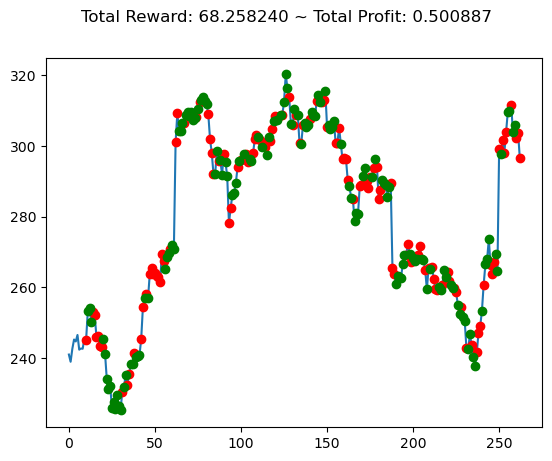

In [4]:
#env = StocksEnv(df=price_history, frame_bound=(50, 303), window_size=10)
env = gym.make('StocksEnvAny1-v0', df=price_history, frame_bound=(50, 303), window_size=10)

observation = env.reset(seed=None)
while True:
    action = env.action_space.sample()
    observation, reward, terminated, truncated, info = env.step(action)

    # env.render()
    if terminated or truncated:
        print("info:", info)
        break

plt.cla()
env.unwrapped.render_all()
plt.show()